# Shared Task: Critical thinking generation
## Loadind Data


In [ ]:
pip install -q social_agents/

In [ ]:
pip show social_agents

In [ ]:
import social_agents

In [ ]:
import tqdm
# Reading the data
import json
import pandas as pd

from social_agents.utils import get_st_data


for key, line in tqdm.tqdm(get_st_data("sample").items()):
    print(key)

    print(line['intervention'])
    input_text = line['intervention']
    break


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python

In [ ]:
import os, getpass

## Prerequisites
env, LLM, ...

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("MISTRAL_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "shared_task_critical_questions"


In [ ]:
# temperature = 0 not for o3-mini


##  1. Zero Shot LLM to start with o3-mini

In [ ]:

from social_agents.graph_tools import BasicCQModel
model_name = "o3-mini"

basic_agent = BasicCQModel(llm_name = model_name, temperature=None ) #interrupt_before=['human_feedback'], checkpointer=memory)


display(Image(basic_agent.graph.get_graph(xray=1).draw_mermaid_png()))

# RUN
# basic_agent.run_experiment()



### Evaulate 

- Run shell 

```shell

python3 eval_scripts/evaluation.py \
    --metric similarity \
    --input_path data_splits/validation.json \
    --submission_path output/output_o3-mini_temperatureNA.json \
    --threshold 0.6 

```

- OUTPUT : output/output_o3-mini_temperatureNA._eval_similarity_06.json



**Overall count**

| **Questions Labels** |  **#**  | **ratio** |
|:--------------------|-------:|---------:|
| useful               | **329** |  **0,59** |
| unhelpful            |      63 |      0,11 |
| Invalid              |       8 |      0,01 |
| Not able to evaluate |     158 |      0,28 |
| **Total**            | **558** |         1 |


**Overall count within each argument**

| **n/3 useful questions per arg** | **# of arguments** | **ratio** |
|:-------------------------------:|-------------------:|:---------:|
|                               0/3 |                 17 |      0,10 |
|                               1/3 |                 51 |      0,27 |
|                               2/3 |             **76** |      0,40 |
|                               3/3 |                 42 |      0,23 |
| **Total**                       |            **186** |         1 |

## Social Agents

In [ ]:
import dataclasses
import operator
from typing import Annotated, Dict, Literal, TypedDict

from social_agents.graph_tools import CQSTAbstractAgent
from langgraph.graph import START, END, StateGraph
from social_agents.objects import  CriticalQuestionList
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
class Confirmation(BaseModel):
    confirmation: str = Field(
        description="The LLM confirms the role assigned to it by simply saying ok."
    )

def _add_to_dict(left: dict | None, right: dict | None) -> dict:
    """
    Merge two dictionaries with list values.
    
    If a key exists in both dictionaries, append the elements from the right 
    dictionary's list to the left dictionary's list. If either input is None, 
    it's treated as an empty dictionary.
    
    Args:
        left (dict or None): The first dictionary. If None, treated as {}.
        right (dict or None): The second dictionary. If None, treated as {}.
        
    Returns:
        dict: A dictionary containing the merged lists for each key.
              For example, merging {'key1': ['e1', 'e2']} with {'key1': ['e_new']}
              will yield {'key1': ['e1', 'e2', 'e_new']}.
    """
    left = left or {}
    right = right or {}
    merged = left.copy()  # Start with a copy of left
    
    
    for key, right_value in right.items():
        if not isinstance(right_value, list):
            right_value = [right_value]

        if key in merged:
            merged[key] = merged[key] + right_value
        else:
            merged[key] = right_value
            
    return merged

# Example usage:

class SocialAgentAnswer(BaseModel):
    critical_question_list: CriticalQuestionList = Field(
        description="The list of all the critical questions and their ranks to criticize and reveal the weaknesses of an argument."
    )
    question_type: Literal["debate", "reflect", "question"]
    prompt: str


class SocialAgentState(TypedDict):
    input_arg: str
    collaborative_strategy: list
    current_round: int = -1 
    round_answer_dict: Annotated[Dict[str, list[SocialAgentAnswer]], _add_to_dict]

    # OutPut
    final_cq: CriticalQuestionList

from langchain_openai import ChatOpenAI
import uuid
from langgraph.types import Command


collaborative_strategy = ["debate"]
agent_trait_lst: list = ["easy_going", "overconfident", "easy_going"]
llm_name = "gpt-4o-mini-2024-07-18"# "o3-mini-2025-01-31"
temperature = 0.75
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
configs = [
{"configurable": {"thread_id": f'{thread_id}_0'}}, {"configurable": {"thread_id": f'{thread_id}_1'}}, {"configurable": {"thread_id": f'{thread_id}_2'}}]
llm_lst = [
    CQSTAbstractAgent._init_llm(llm_name, temperature)
    for _ in range(len(agent_trait_lst))
]
validator_llm = CQSTAbstractAgent._init_llm(llm_name, temperature)


def llm_role_node(state: SocialAgentState)  -> Command[Literal["question_node", "__end__"]]:
    are_all_roles_confirmed = True
    for i, llm in enumerate(llm_lst):
        with open(f"prompts/trait_{agent_trait_lst[i]}.txt", "r") as f:
            trait_prompt = f.read()

        response = llm.with_structured_output(Confirmation).invoke(
            trait_prompt
        )
        if response.confirmation.lower() == "ok":
            print(f"role {agent_trait_lst[i]} confirmed")
            
        else:
            print(f"Unconfirmed Role: {response.confirmation}")
            are_all_roles_confirmed = False
            break
            
    goto_  = "question_node" if are_all_roles_confirmed else END
    return Command(
        update={
            "current_round": -1},
        goto=goto_
        )





def question_node(state: SocialAgentState)-> Command[Literal["debate_node", "reflect_node", "validate_node"]]:
    round_answer_dict = {}
    for i, llm in enumerate(llm_lst):
        print(f"ROLE {i} remember:", llm.invoke("Do you remember what is you ROLE? ",))
        #print(f"arg {i} :", llm.invoke("Can you show the argument that I asked you to evaluate? "))
        # with open("prompts/system.txt", "r") as f:
        #    system_prompt = f.read()
        with open("prompts/question.txt", "r") as file:
            instructions = file.read()

        instructions = instructions.format(
            input_arg=state["input_arg"],
        )
        response = llm.with_structured_output(CriticalQuestionList).invoke(instructions
                                                                           )
        answer: SocialAgentAnswer = SocialAgentAnswer(
            critical_question_list=response,
            question_type="question",
            prompt=instructions,
        )
        round_answer_dict[f"agent{i}"] = [answer]

    next_round = state["current_round"] + 1
    goto = _decide_next(state["collaborative_strategy"], next_round)
    return Command(
        update={
            "round_answer_dict":round_answer_dict,
            "current_round": next_round
            },
        goto=goto
    )




def debate_node(state: SocialAgentState)-> Command[Literal["debate_node", "reflect_node", "validate_node"]]:
    answer_round= {}
    last_answers = [
        state["round_answer_dict"][f"agent{x}"][-1] for x, _ in enumerate(llm_lst)
    ]
    for i, llm in enumerate(llm_lst):

        with open("prompts/strategy_debate.txt", "r") as file:
            instructions = file.read()

        # Get others answer and own answer

        other_agents_response_str = ""
        own_answer_str = ""
        cq_str = "\n- critical question {id}: '{cq}', reasoning: '{reason}'.\n"
        for a_num, other_ in enumerate(last_answers):
            if a_num != i: 
                other_agents_response_str += f"## Agent{a_num+1}:"
            for cq in other_.critical_question_list.critical_questions:
                if a_num != i: 
                    other_agents_response_str = (
                        other_agents_response_str
                        + cq_str.format(id = cq.id, cq=cq.critical_question, reason=cq.reason)
                    )
                else:
                    own_answer_str = own_answer_str + cq_str.format(id = cq.id, cq=cq.critical_question, reason=cq.reason)
            if a_num != i: 
                other_agents_response_str += "\n"

        instructions = instructions.format(
            input_arg=state["input_arg"],
            own_answer = own_answer_str,
            other_agents_response=other_agents_response_str,
        )

        response = llm.with_structured_output(CriticalQuestionList).invoke(instructions)
        answer: SocialAgentAnswer = SocialAgentAnswer(
            critical_question_list=response,
            question_type="debate",
            prompt=instructions,
        )

        #round_answer_dict[f"agent{i}"].append(answer)
        answer_round[f"agent{i}"] = [answer]
        #state["round_answer_dict"] = round_answer_dict

    
    next_round = state["current_round"] + 1
    goto = _decide_next(state["collaborative_strategy"], next_round)
    return Command(
        update={
            "round_answer_dict":answer_round,
            "current_round": next_round
            },
        goto=goto
    )
    
    
    
def _decide_next(collaborative_strategy_lst, current_round) -> Literal["debate", "reflect", "validate"]:
    if len(collaborative_strategy_lst) > current_round:
        print(f'Moving to state: {collaborative_strategy_lst[current_round]}')
        return f'{collaborative_strategy_lst[current_round]}_node'
    else:
        print("Moving to state: validate_node")
        return "validate_node"



def reflect_node(state: SocialAgentState)-> Command[Literal["debate_node", "reflect_node", "validate_node"]]:
    round_answer_dict={}
    for i, llm in enumerate(llm_lst):

        with open("prompts/strategy_reflect.txt", "r") as file:
            instructions = file.read()

        # Get others answer
        previous_answer = state["round_answer_dict"][f"agent{i}"][-1]
        own_answer_str = ""
        cq_str = "\n- critical question {id}: '{cq}', reasoning: '{reason}'.\n"
        for cq in previous_answer.critical_question_list.critical_questions:
            own_answer_str = own_answer_str + cq_str.format(id = cq.id, cq=cq.critical_question, reason=cq.reason)
        instructions = instructions.format(
            input_arg=state["input_arg"], own_answer=own_answer_str
        )

        response = llm.with_structured_output(CriticalQuestionList).invoke(instructions)
        answer: SocialAgentAnswer = SocialAgentAnswer(
            critical_question_list=response,
            question_type="reflect",
            prompt=instructions,
        )

        #round_answer_dict[f"agent{i}"].append(answer)
        round_answer_dict[f"agent{i}"] = [answer]
        #state["round_answer_dict"] = round_answer_dict
    next_round = state["current_round"] + 1
    goto = _decide_next(state["collaborative_strategy"], next_round)
    return Command(
        update={
            "round_answer_dict":round_answer_dict,
            "current_round": next_round
            },
        goto=goto
    )

def validate_node(state: SocialAgentState)-> Command[Literal[ "__end__"]]:
    with open("prompts/validator.txt", "r") as file:
        instructions = file.read()
    # Get others answer
    round_answer_dict = state["round_answer_dict"]
    others_answers = [
        round_answer_dict[f"agent{x}"][-1] for x, _ in enumerate(llm_lst)
    ]
    other_agents_response_str = ""
    other_cq_str = "\n- critical question {id}: '{cq}'.\n" # reasoning: '{reason}'
    for a_num, other_ in enumerate(others_answers):
        other_agents_response_str += f"Agent{a_num+1}:"
        for cq in other_.critical_question_list.critical_questions:
            other_agents_response_str = (
                other_agents_response_str
                + other_cq_str.format(id = cq.id, cq=cq.critical_question, reason=cq.reason)
            )
        other_agents_response_str += "\n\n"
    instructions = instructions.format(
        input_arg=state["input_arg"],
        other_agents_response=other_agents_response_str,
    )
    response = validator_llm.with_structured_output(CriticalQuestionList).invoke(instructions)
    print(instructions)
    return {"final_cq": response}



workflow = StateGraph(SocialAgentState)

workflow.add_node("llm_role_node", llm_role_node)
workflow.add_node("question_node", question_node)
workflow.add_node("debate_node", debate_node)
workflow.add_node("reflect_node", reflect_node)
workflow.add_node("validate_node", validate_node)

workflow.add_edge(START, "llm_role_node")
#workflow.add_edge("llm_role_node", "question_node")
#workflow.add_conditional_edges("question_node",  ["debate_node", "reflect_node", "validate_node"])
#workflow.add_conditional_edges("debate_node",  ["debate_node", "reflect_node", "validate_node"])
#workflow.add_conditional_edges("reflect_node",  ["debate_node", "reflect_node", "validate_node"])
workflow.add_edge("validate_node", END)
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.runnables.graph import CurveStyle
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)


In [ ]:
for event in app.stream({"collaborative_strategy": collaborative_strategy,
                         "input_arg": "I am human therefore I am mortal"}, config, stream_mode="values"):
    
    final_cq = event.get("final_cq", "")
    if final_cq:
        print(final_cq)


In [ ]:
import uuid

response = app.invoke({"collaborative_strategy": collaborative_strategy, "input_arg": "I am human therefore I am mortal"}, config)

In [ ]:
response['final_cq']
response['round_answer_dict'].keys()

In [ ]:
ag_out = response['round_answer_dict']['agent2']
len(ag_out)
ag_out[0].model_dump()

In [ ]:
ag_out = response['round_answer_dict']['agent0']
len(ag_out)
#ag_out[1].model_dump()

In [ ]:
display(Image(app.get_graph(xray=1).draw_mermaid_png(curve_style=CurveStyle.LINEAR, padding=0)))

In [ ]:
response.keys()

In [ ]:
response['final_cq']

In [11]:
import dataclasses
import operator
from typing import Annotated, Dict, Literal, Optional, TypedDict

from social_agents.graph_tools import CQSTAbstractAgent, SocialAgentBuilder
from langgraph.graph import START, END, StateGraph
from social_agents.objects import  CriticalQuestionList
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage





# Example usage:








from langchain_openai import ChatOpenAI
import uuid
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}


# Set these
collaborative_strategy= ["debate", "reflect"]
agent_trait_lst: list[str] = ["easy_going",  "overconfident", "easy_going"]


trait_str = "".join(sorted([x[0] for x in agent_trait_lst]))
strategy_str = "".join([x[0] for x in collaborative_strategy])
n = len(agent_trait_lst)
experiment_name = f"social_n{n}_T{trait_str}_S{strategy_str}_{thread_id}".split("-")[0]
llm_name = "gpt-4o-mini-2024-07-18"# "o3-mini-2025-01-31"
#temperature = 0.75

social_agent = SocialAgentBuilder(llm_name = llm_name,
                                  llm_num = n,
                                  experiment_name=experiment_name,
                                  temperature=0.7,
                                  collaborative_strategy=collaborative_strategy,
                                  agent_trait_lst=agent_trait_lst)





Initializing LLM gpt-4o-mini-2024-07-18
Building Agentic Graph
BUILDING
BUILDING DONE
run `display(Image(graph.get_graph(xray=1).draw_mermaid_png()))` to see your Agentic Graph
experiment name:  social_n3_Teeo_Sdr_22c9f336


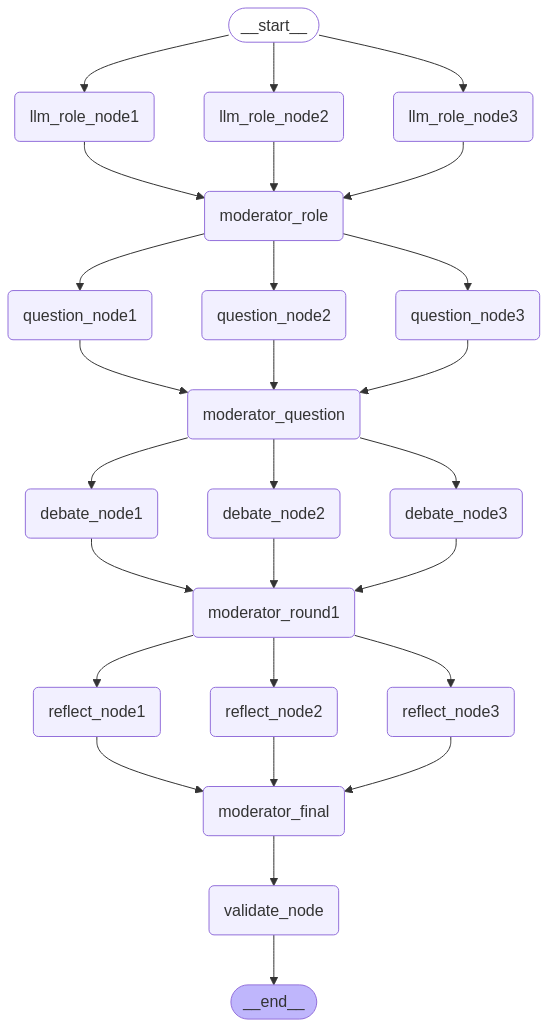

In [12]:
from IPython.display import Image, display


display(Image(social_agent.graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
response = app.invoke({"collaborative_strategy": collaborative_strategy, "input_arg": "I am human therefore I am mortal"}, config)
